# English project

Download fastai libraries


In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.0 MB/s 
     |████████████████████████████████| 197 kB 56.1 MB/s 
     |████████████████████████████████| 1.2 MB 46.3 MB/s 
     |████████████████████████████████| 60 kB 7.8 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Downloading images

Here we will download images we need to train and validate our model. The model will classify dog breeds such as bulldog, pug, husky, and labrador.

In [3]:
results = search_images_ddg('bulldog', max_images=150)
len(results), results[0]

(150,
 'https://www.petcitypetshops.net/wp-content/uploads/2019/05/22932-9513.jpg')

In [4]:
dest = 'images/bulldog.jpg'
download_url(results[0], dest)

Path('images/bulldog.jpg')

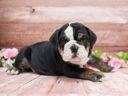

In [5]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [6]:
dog_types = 'pug', 'labrador', 'husky', 'bulldog'
path = Path('dogs')

In [7]:
if not path.exists():
  path.mkdir()
  for o in dog_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} dog', max_images=150)
    download_images(dest, urls=results)

In [8]:
fns = get_image_files(path)
fns

(#582) [Path('dogs/bulldog/00000060.jpg'),Path('dogs/bulldog/00000108.jpg'),Path('dogs/bulldog/00000085.jpg'),Path('dogs/bulldog/00000063.jpg'),Path('dogs/bulldog/00000076.jpg'),Path('dogs/bulldog/00000118.jpeg'),Path('dogs/bulldog/00000144.jpg'),Path('dogs/bulldog/00000103.jpeg'),Path('dogs/bulldog/00000110.jpg'),Path('dogs/bulldog/00000023.jpg')...]

In [9]:
# Verifying failed images
failed = verify_images(fns)
failed

(#11) [Path('dogs/bulldog/00000148.jpg'),Path('dogs/bulldog/00000089.jpg'),Path('dogs/bulldog/00000027.jpg'),Path('dogs/bulldog/00000091.jpg'),Path('dogs/bulldog/00000059.JPG'),Path('dogs/husky/00000104.jpeg'),Path('dogs/husky/00000111.jpg'),Path('dogs/labrador/00000126.jpg'),Path('dogs/pug/00000079.jpg'),Path('dogs/pug/00000099.jpg')...]

In [10]:
failed.map(Path.unlink)

(#11) [None,None,None,None,None,None,None,None,None,None...]

## From data to dataloaders

Transform the data into dataloaders. Dataloaders is a thin class that just stores whatever dataload object you pass to it, and makes them available as train and valid sets.

In [11]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [12]:
dls = dogs.dataloaders(path)

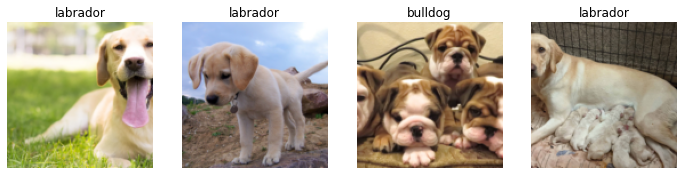

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

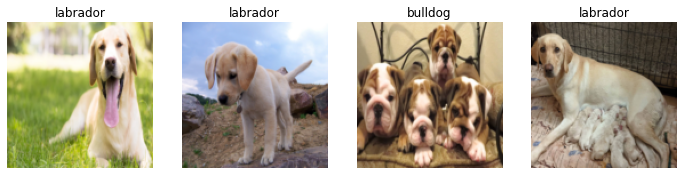

In [14]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

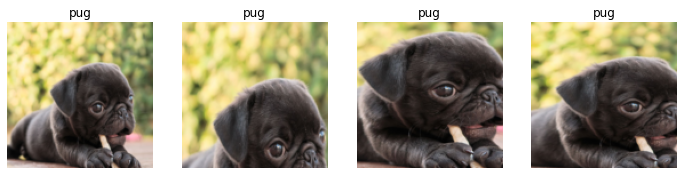

In [15]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data augmentation

With the intetion to create variations of the input data without changing its meaning we augmented the data with the standard set of augmentations `aug_transform`.

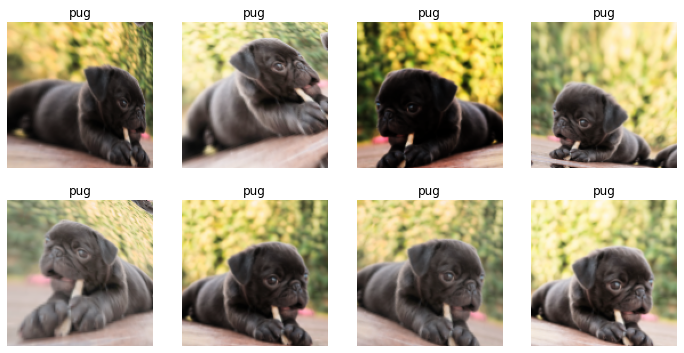

In [16]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training model

Then we use the data to train our classifier with a cnn model.

In [17]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.559798,0.147595,0.052632,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.252009,0.073632,0.035088,00:26
1,0.160605,0.073524,0.035088,00:25
2,0.117952,0.060292,0.035088,00:31
3,0.090848,0.055838,0.026316,00:25


Here we can observe the behaviour our false positives in the model and which class are they predicting wrong.

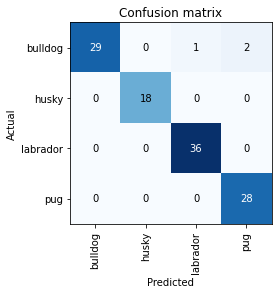

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

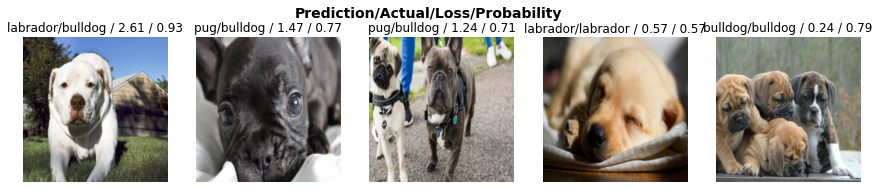

In [20]:
interp.plot_top_losses(5, nrows=1)

## Exporting our model

After the entire process we export our model to use in the web application.

In [22]:
learn.export(fname='export.pkl')

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [26]:
learn_inf.predict('images/bulldog.jpg')

('bulldog',
 TensorBase(0),
 TensorBase([9.9998e-01, 2.5922e-08, 7.8209e-06, 7.6165e-06]))

In [28]:
learn_inf.dls.vocab

['bulldog', 'husky', 'labrador', 'pug']